In [91]:
from ultralytics import YOLO

In [92]:
import torch
torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Train Yolo

In [93]:
# Train YOLO 

# model = YOLO('yolov8n-obb.pt')

# results = model.train(data="Indonesian_License_Plate_Dataset (Bike)/data.yaml", epochs=80, device=1, imgsz=640)

Detect

In [94]:
# Model Declaration
model = YOLO('model-80epcs/obb/train/weights/best.pt')

In [95]:
# Demo Detection 
import os
import random

# Take random pic
# dataset_location = 'C:/Users/Frederick/Documents/Project/Paperless Parking/Code/Object Detection/Indonesian_License_Plate_Dataset (Bike)'
# random_file = random.choice(os.listdir(os.path.join(dataset_location, 'test', 'images')))
# file_name = os.path.join(dataset_location, 'test', 'images', random_file)

# Static file
file_name = "datasets/test_image_7.jpg"

# results = model(file_name)
# print(results)



Display the plate


0: 384x640 23.6ms
Speed: 1.0ms preprocess, 23.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
[[[44 61 64]
  [44 61 64]
  [44 61 64]
  ...
  [23 18 79]
  [20 17 79]
  [19 16 78]]

 [[44 61 64]
  [44 61 64]
  [44 61 64]
  ...
  [22 17 78]
  [19 16 78]
  [19 16 78]]

 [[44 60 66]
  [44 60 66]
  [44 60 66]
  ...
  [21 16 78]
  [19 16 78]
  [18 15 77]]

 ...

 [[45 66 81]
  [45 66 81]
  [46 67 82]
  ...
  [ 3  4  8]
  [ 3  4  8]
  [ 3  4  8]]

 [[45 66 81]
  [45 66 81]
  [46 67 82]
  ...
  [ 3  4  8]
  [ 3  4  8]
  [ 3  4  8]]

 [[45 66 81]
  [45 66 81]
  [46 67 82]
  ...
  [ 3  4  8]
  [ 3  4  8]
  [ 3  4  8]]]
[[    0.99358    0.013891        -345]
 [  -0.013601     0.98964      -317.3]
 [ -3.634e-11  1.3218e-09           1]]


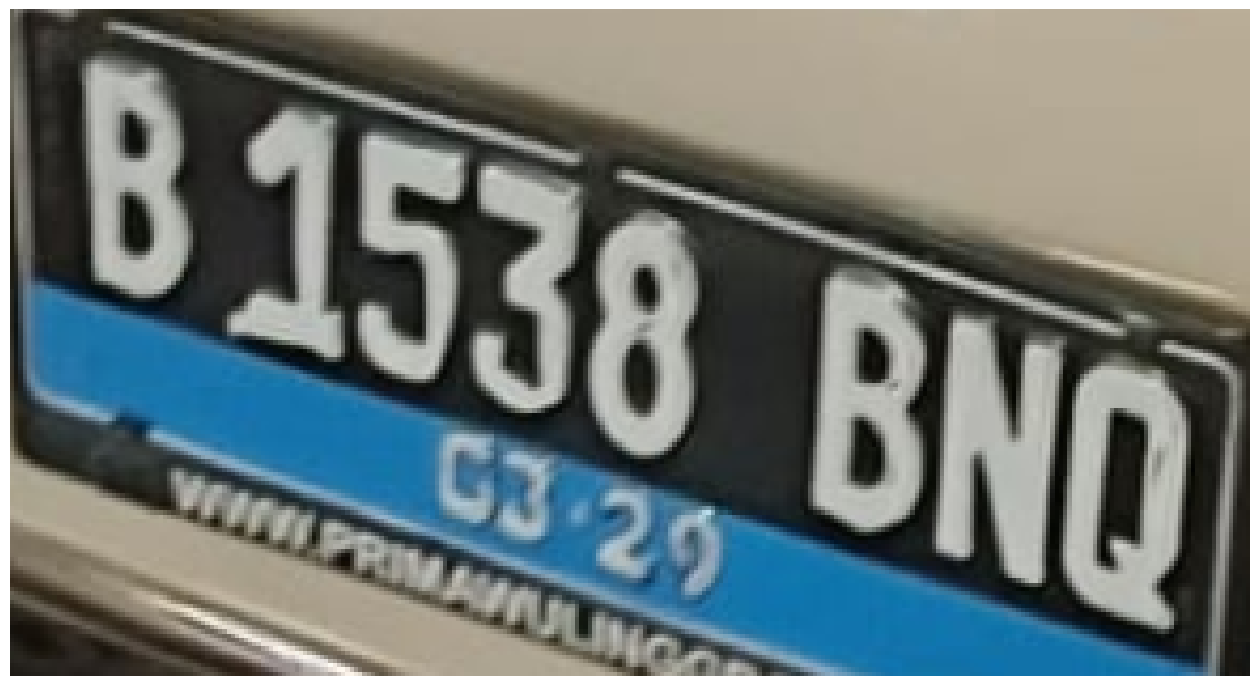

In [96]:
import supervision as sv
import cv2 as cv
import numpy as np

image = np.array(cv.imread(file_name))

def extract_license_plates(image, detections):
    license_plates = []
    for i,class_id in enumerate(detections.class_id):
        if detections.data['class_name'][i] == 'License_Plate':
            BoxCoordinate= np.float32(detections[i].data['xyxyxyxy'][0])
            idxPoint1 = np.argmin(BoxCoordinate[:, 1])
            xCurrent = BoxCoordinate[idxPoint1][0]
            xFoward = BoxCoordinate[(idxPoint1 + 1) % 4][0]
            xBackward = BoxCoordinate[(idxPoint1 - 1) % 4][0]
            if(xFoward <= xCurrent):
                xBackward, xFoward = xFoward, xBackward
                
            if((xFoward - xCurrent == 0) | (xBackward - xCurrent == 0) ):
                x1,y1,x2,y2 = class_id.xyxy
                x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
                imageCropped = image[y1:y2,x1:x2]
                area = (x2 - x1) * (y2 -y1)
                license_plates.append([imageCropped,area,i])
                continue
            elif((xFoward - xCurrent) > (xCurrent - xBackward)):
                idxPoint2 = np.argmax(BoxCoordinate[:, 0])
                idxPoint3 = np.argmin(BoxCoordinate[:, 0])
                idxPoint4 = np.argmax(BoxCoordinate[:, 1])
            else:
                idxPoint2 = idxPoint1
                idxPoint3 = np.argmax(BoxCoordinate[:, 1])
                idxPoint1 = np.argmin(BoxCoordinate[:, 0])
                idxPoint4 = np.argmax(BoxCoordinate[:, 0])
            
            # top left corner, top right corner, bottom left corner, bottom right corner
            val = 3
            point1 = np.array([BoxCoordinate[idxPoint1][0] + val, BoxCoordinate[idxPoint1][1] + val], dtype="float32")
            point2 = np.array([BoxCoordinate[idxPoint2][0] - val, BoxCoordinate[idxPoint2][1] + val], dtype="float32")
            point3 = np.array([BoxCoordinate[idxPoint3][0] + val, BoxCoordinate[idxPoint3][1] - val], dtype="float32")
            point4 = np.array([BoxCoordinate[idxPoint4][0] - val, BoxCoordinate[idxPoint4][1] - val], dtype="float32")
            points = [point1, point2, point3, point4]
            width = int(max(np.linalg.norm(point2 - point1), np.linalg.norm(point4 - point2)))
            height = int(max(np.linalg.norm(point3 - point1), np.linalg.norm(point4 - point2)))
            dst = np.array([
                [0, 0],
                [width - 1, 0],
                [0, height - 1],
                [width - 1, height - 1],
            ], dtype="float32")

            M = cv.getPerspectiveTransform(np.float32(points), dst)
            imageCropped = cv.warpPerspective(image, M, (width, height))
            print(image)
            area = width * height
            license_plates.append([imageCropped,area,i])
    return license_plates

results = model(image)
detections = sv.Detections.from_ultralytics(results[0])
license_plates = extract_license_plates(image, detections)
nearest_license_plate = max(license_plates, key=lambda x: x[1])
sv.plot_image(image=nearest_license_plate[0], size=(16, 16))

Read The Plate

In [97]:
import easyocr
import cv2 as cv
import matplotlib.pyplot as plt

def detect_text_from_image(image):
    DenoiseImage = cv.fastNlMeansDenoising(image, None, 7, 5, 3)
    GrayImage = cv.cvtColor(DenoiseImage, cv.COLOR_BGR2GRAY)
    _, image = cv.threshold(GrayImage, 0, 255, cv.THRESH_OTSU + cv.THRESH_BINARY )
    reader = easyocr.Reader(['en'])
    results = reader.readtext(image)
    text = ""
    for result in results:
        text += result[1] + " "
    plt.hist(image.ravel(), 256, [0, 256])
    sv.plot_image(image=image, size=(16, 16))
    return text

# Usage example

text = detect_text_from_image(nearest_license_plate).upper()
print(text)


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'fastNlMeansDenoising'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
import re

remove_chars = '.,@#!$%^&*()[]{}|\\:;\'"<>?/`~_'
translation_table = str.maketrans('', '', remove_chars)

def cleanText(text : str):

    MissreadPossibility = {
        "8": "B",
        "1": "I", 
        "0": "O",
        "4": "H",
        "2": "Z"
    }

    MissreadPossibilityNum = {
        "B":"8",
        "I":"1", 
        "O":"0",
        "H":"4",
        "Z":"2"
    }
    
    text = text.replace(' ','')

    text = list(text)
    word_section = 1
    word_count = 0
    for i,char in enumerate (text[:-1]):
        if(word_section == 3):
            word_count+=1
        if(word_section % 2 == 1):
            if text[i] in MissreadPossibility:
                text[i] = MissreadPossibility[text[i]]
        else:
            if text[i] in MissreadPossibilityNum:
                text[i] = MissreadPossibilityNum[text[i]]
        if (text[i].isalpha() and text[i + 1].isdigit()) or (text[i].isdigit() and text[i + 1].isalpha()):
            word_section+=1
        if (word_section >= 4) or word_count >= 3:
            return ''.join(text)[0:i+1].translate(translation_table)
    return ''.join(text).translate(translation_table)
print(cleanText(text))

B1538BNQ
